In [1]:
import os.path
 
import numpy as np
import torch.utils.data
import torchvision.utils
from torch import nn, optim
from torch.nn import functional
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import umap.umap_ as umap
import sklearn.datasets
import pandas as pd

     -------------------------------------- 134.4/134.4 kB 1.3 MB/s eta 0:00:00
     -------------------------------------- 384.1/384.1 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
class VAE(nn.Module):
    def __init__( 
        self,
        input_shape,
        device,
        width,
        latent_dimensionality,
    ):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.n_input_values = np.prod(input_shape).item()
        self.device = device
        self.width = width
        self.latent_dimensionality = latent_dimensionality
 
        # Define encoding layers.
        self.input_encoder = nn.Linear(
            self.n_input_values, self.width
        )
        self.mean_encoder = nn.Linear(
            self.width, self.latent_dimensionality
        )
        self.var_encoder = nn.Linear(
            self.width, self.latent_dimensionality
        )
 
        # Define decoding layers.
        self.latent_decoder = nn.Linear(
            self.latent_dimensionality, self.width
        )
        self.final_decoder = nn.Linear(
            self.width, self.n_input_values
        )
 
    def encode(self, original):
        encoded_input = functional.relu(
            self.input_encoder(original)
        )
        return (
            self.mean_encoder(encoded_input),
            self.var_encoder(encoded_input),
        )
 
    def reparameterize(self, mean, log_variance):
        deviation = torch.exp(0.5 * log_variance)
        noise = torch.randn_like(
            deviation, device=self.device
        )
        return mean + noise * deviation
 
    def decode(self, latent):
        decoded_latent = functional.relu(
            self.latent_decoder(latent)
        )
        final = torch.sigmoid(
            self.final_decoder(decoded_latent)
        )
        return final.view(-1, *self.input_shape)
 
    def forward(self, original):
        mean, log_variance = self.encode(
            original.view(-1, self.n_input_values)
        )
        latent = self.reparameterize(mean, log_variance)
        decoded = self.decode(latent)
        return decoded, mean, log_variance
 
    def variational_loss_function(
        self, decoded, original, mean, log_variance
    ) -> torch.Tensor:
        entropy = functional.binary_cross_entropy(
            decoded,
            original.view(-1, *self.input_shape),
            reduction="sum",
        )
 
        divergence = -0.5 * torch.sum(
            1
            + log_variance
            - mean.pow(2)
            - log_variance.exp()
        )
 
        return entropy + divergence
 

mean_list = []

def main( 
    batch_size,
    width,
    latent_dimensionality,
    n_epochs,
    learning_rate,
    out_path,
    image_extension,
    max_saves_per_epoch,
 ):
    # Select GPU if available.
    device = (
        torch.device("cuda")
        if torch.cuda.is_available()
        else torch.device("cpu")
    )
 
    # Set seed.
    torch.manual_seed(0)
 
    # Prepare data.
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(
            "data",
            train=True,
            download=True,
            transform=transforms.ToTensor(),
        ),
        batch_size=batch_size,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(
            "data",
            train=False,
            download=True,
            transform=transforms.ToTensor(),
        ),
        batch_size=batch_size,
        shuffle=True,
    )
 
    # Prepare batch to observe progress.
    fixed_batch, _ = next(iter(test_loader))
    grid = torchvision.utils.make_grid(fixed_batch)
    os.makedirs(out_path, exist_ok=True)
    path = os.path.join(
        out_path, f"original.{image_extension}"
    )
    torchvision.utils.save_image(grid, path)
    fixed_batch = fixed_batch.to(device)
 
    # Prepare random latent to observe progress.
    fixed_latent = noise = torch.randn(
        [batch_size, latent_dimensionality], device=device
    )
 
    # Prepare model.
    model = VAE(
        input_shape=fixed_batch.shape[1:],
        width=width,
        latent_dimensionality=latent_dimensionality,
        device=device,
    ).to(device)
    optimizer = optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-5
    )
 
    # Process epochs.
    n_batches = len(train_loader)
    for i_epoch in range(n_epochs):
        model.train()
        n_save_batches = int(
            (1 - i_epoch / n_epochs) * max_saves_per_epoch
            + 1
        )
        save_interval = int(n_batches / n_save_batches)
        # Train model.
        for i_batch, (batch, _) in enumerate(
            train_loader
        ):
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstruction, mean, log_variance = model(
                batch
            )
            mean_list.append((reconstruction, mean, log_variance))
            loss = model.variational_loss_function(
                reconstruction, batch, mean, log_variance
            )
            loss.backward()
            optimizer.step()
 
            if i_batch % save_interval == 0:
                # Print progress.
                print(f"{i_epoch = }, {i_batch = }")
 
                # Process fixed batch.
                model.eval()
                reconstruction, _, _ = model(fixed_batch)
 
                grid = torchvision.utils.make_grid(
                    reconstruction
                )
                path = os.path.join(
                    out_path,
                    f"reconstruction-{i_epoch:0{len(str(n_epochs))}}"
                    f"-{i_batch:0{len(str(n_batches))}}"
                    f".{image_extension}",
                )
                torchvision.utils.save_image(grid, path)
 
                # Process fixed latent.
                decoded = model.decode(fixed_latent)
 
                grid = torchvision.utils.make_grid(
                    decoded
                )
                path = os.path.join(
                    out_path,
                    f"random-{i_epoch:0{len(str(n_epochs))}}"
                    f"-{i_batch:0{len(str(n_batches))}}"
                    f".{image_extension}",
                )
                torchvision.utils.save_image(grid, path)
 
 
main(
    batch_size=64,
    width=400,
    latent_dimensionality=20,
    n_epochs=10,
    learning_rate=1e-3,
    out_path="output",
    image_extension="png",
    max_saves_per_epoch=10,
)

i_epoch = 0, i_batch = 0
i_epoch = 0, i_batch = 85
i_epoch = 0, i_batch = 170
i_epoch = 0, i_batch = 255
i_epoch = 0, i_batch = 340
i_epoch = 0, i_batch = 425
i_epoch = 0, i_batch = 510
i_epoch = 0, i_batch = 595
i_epoch = 0, i_batch = 680
i_epoch = 0, i_batch = 765
i_epoch = 0, i_batch = 850
i_epoch = 0, i_batch = 935
i_epoch = 1, i_batch = 0
i_epoch = 1, i_batch = 93
i_epoch = 1, i_batch = 186
i_epoch = 1, i_batch = 279
i_epoch = 1, i_batch = 372
i_epoch = 1, i_batch = 465
i_epoch = 1, i_batch = 558
i_epoch = 1, i_batch = 651
i_epoch = 1, i_batch = 744
i_epoch = 1, i_batch = 837
i_epoch = 1, i_batch = 930
i_epoch = 2, i_batch = 0
i_epoch = 2, i_batch = 104
i_epoch = 2, i_batch = 208
i_epoch = 2, i_batch = 312
i_epoch = 2, i_batch = 416
i_epoch = 2, i_batch = 520
i_epoch = 2, i_batch = 624
i_epoch = 2, i_batch = 728
i_epoch = 2, i_batch = 832
i_epoch = 2, i_batch = 936
i_epoch = 3, i_batch = 0
i_epoch = 3, i_batch = 117
i_epoch = 3, i_batch = 234
i_epoch = 3, i_batch = 351
i_epoch = 3

(array([[ 0.,  0.,  3.,  9.,  8.,  4.,  4.,  4.,  0.,  0.],
        [ 0.,  0.,  2.,  6.,  7.,  8.,  4.,  5.,  0.,  0.],
        [ 0.,  1.,  1.,  6.,  8.,  8.,  7.,  0.,  1.,  0.],
        [ 0.,  0.,  2.,  8.,  8.,  6.,  4.,  3.,  1.,  0.],
        [ 1.,  0.,  1.,  5., 10.,  6.,  6.,  3.,  0.,  0.],
        [ 0.,  0.,  2.,  6.,  9.,  6.,  6.,  3.,  0.,  0.],
        [ 0.,  0.,  0.,  3.,  7.,  9.,  9.,  3.,  1.,  0.],
        [ 0.,  1.,  2.,  4.,  5.,  9.,  4.,  4.,  2.,  1.],
        [ 0.,  0.,  6.,  3.,  6., 10.,  3.,  3.,  0.,  1.],
        [ 0.,  0.,  1.,  5., 12.,  4.,  8.,  2.,  0.,  0.],
        [ 0.,  3.,  2.,  7.,  7.,  5.,  4.,  2.,  2.,  0.],
        [ 0.,  0.,  2.,  8., 10.,  3.,  6.,  2.,  0.,  1.],
        [ 1.,  0.,  2.,  6.,  7.,  7.,  4.,  5.,  0.,  0.],
        [ 0.,  1.,  5.,  4.,  5.,  6.,  7.,  4.,  0.,  0.],
        [ 0.,  1.,  2.,  6., 10.,  4.,  6.,  3.,  0.,  0.],
        [ 0.,  0.,  4.,  4.,  8.,  9.,  5.,  1.,  1.,  0.],
        [ 0.,  1.,  2.,  6.,  7.,  7.,  

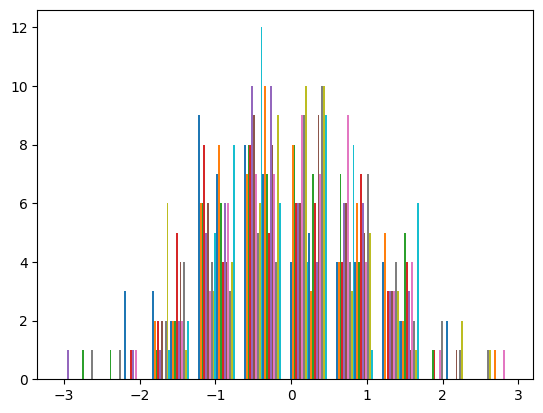

In [23]:
#plt.hist(means)

In [3]:
digits = sklearn.datasets.fetch_openml('Fashion-MNIST')

digits_df = pd.DataFrame(digits.data)
digits_df['digit'] = pd.Series(digits.target).map(lambda x: 'Digit {}'.format(x))

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,digit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Digit 9
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,114.0,130.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,Digit 0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Digit 0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,96.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Digit 3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Digit 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Digit 9
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Digit 1
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Digit 8
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Digit 1


In [15]:
embedding = umap.UMAP(random_state=42).fit(digits.data.iloc[:,1:784]).transform(digits.data.iloc[:,1:784])

Text(0.5, 1.0, 'UMAP projection of the Fashion MNIST dataset')

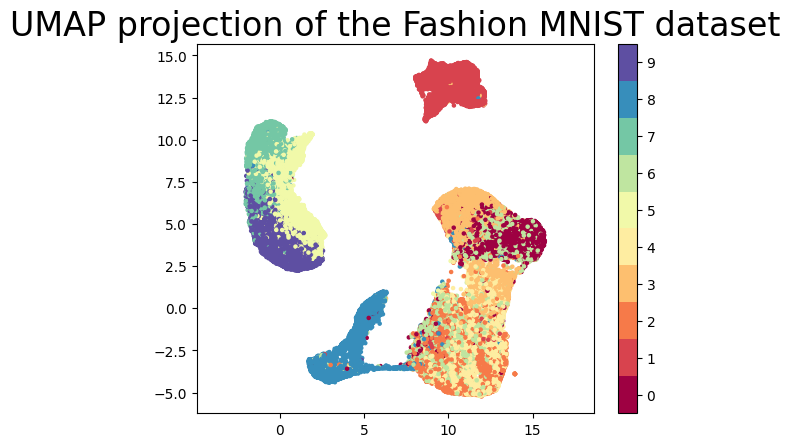

In [18]:
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', c=np.array(digits.target).astype(int), s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Fashion MNIST dataset', fontsize=24)